# The Adam Optimizer

The primary usefulness of the Adam optimizer is its (alleged) improved capabilities over other optimizers in almost all cases. To demonstrate this improvement, we are going to implement several different optimizers on a basic toy problem and basic visual functions.

First, some set up:

In [2]:
import time
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy
from contextlib import contextmanager
import numpy as np
import torch
from torchmetrics.classification import Accuracy
import matplotlib.pyplot as plt

### Functions to Use Later

In [3]:
# function for measuring time elapsed during each model run
@contextmanager
def time_block(label="Elapsed time"):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print(f"{label} elapsed time: {end - start:.6f} seconds")

# function for measuring accuracy of classifier
def get_acc(X_test, y_test, classifier):
    num_classes = 10
    acc = Accuracy(task="multiclass", num_classes=num_classes)
    classifier.eval()
    with torch.no_grad():
        y_pred = classifier(torch.from_numpy(X_test).float())  # [899, 10] 
        y_true = torch.tensor(y_test)                           # [899]
        # Convert logits → predicted class indices
        y_pred_labels = torch.argmax(y_pred, dim=1)             # [899]
    accuracy = acc(y_pred_labels, y_true).item()
    print(
        f"Final accuracy: {accuracy:.4f}"
    )


### Toy digits dataset

In [4]:
# Load in and reshape the digits dataset
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) #flattens the data
X_train, X_test, y_train, y_test = train_test_split( #splits into training and testing sets
    data, digits.target, test_size=0.5, shuffle=False)


### Basic Classification Model

Now we are going to define a classification model class. This is a pretty basic model, but it will suit our purposes for comparing the performances of these different optimizers.


In [ ]:
class classifier_model(torch.nn.Module):
    
    def __init__(self,input_size,output_size):
        super().__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Linear(input_size,output_size)) # single layer model
        
    def forward(self,X):
        z = self.layer1(X)         # Apply the first layer (and only)
        return(z)            # Return the result (and the latent space variable

#training a model automatically
#takes in the loss function, optimizer, model itself, and training data
def train_model(L,optimizer,classifier, X_train, y_train, display=False):
    n_epochs = 15
    for epoch in range(n_epochs):
        loss = 0
        for X,y in zip(X_train,y_train): #y are labels
            labels = torch.tensor(y)
            inputs = torch.from_numpy(X).to(torch.float32)
        
            optimizer.zero_grad()  # Clear gradients
            outputs = classifier(inputs) #gets the outputs of the model
            train_loss = L(outputs,labels) #gets loss
            train_loss.backward() # compute accumulated gradients
            optimizer.step()# perform parameter update based on current gradients
            loss += train_loss.item() # add the mini-batch training loss to epoch loss
        loss = loss / len(X_train) # compute the epoch training loss
        if display:
            print(f"epoch : {epoch + 1}/{n_epochs}, loss = {loss}")
    return loss #this is the final loss at the end of all the training process
            

In [6]:
# get_gradient_info takes three inputs (the test function, the optimizer,
# and the input data as a tensor with grad = True)
# and returns 1) a list of all weights as they were updated,
# 2) the z_values, or the value of the function when evaluated at that weight combo,
# and 3) the grad_list, or the list of gradients at each time step.

def get_gradient_info(test_f, optimizer, x):
    
    final_list = []
    grad_list = []
    for step in range(100):
        optimizer.zero_grad()
        z = test_f(x[0],x[1])
        z.backward()
        optimizer.step()
        grad_list.append(x.grad)
        final_list.append([x.detach().numpy()[0],x.detach().numpy()[1]])

    weights = np.array(final_list)
    weights = weights.squeeze()

    z_values = []
    for dot in weights:
        z_values.append(test_f(dot[0],dot[1]))

    return weights, z_values, grad_list


In [7]:
# make_graphic makes a 3d figure to visualize the loss surface.
# test_f is the function we are trying to minimize
# weights are the value of the inputs we record as the gradient moves along
# z_values is the value of the function at those various weights
# grad_list is the value of the gradient at those various points

def make_graphic(test_f,weights,z_values,grad_list,elev=30,azim=70):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(weights[:,0],weights[:,1],z_values,s=5)

    m_plot = 500
    x1_plot = np.linspace(weights[:,0].min()-.1,weights[:,0].max()+.1,m_plot)
    x2_plot = np.linspace(weights[:,1].min()-.1,weights[:,1].max()+.1,m_plot)
    x1_plot, x2_plot = np.meshgrid(x1_plot,x2_plot)
    #y_plot = 2*x1_plot**2 + 8*x2_plot**2
    y_plot = test_f(x1_plot,x2_plot)
    #y_plot = (3-x1_plot)**2 + 7*(x2_plot-x1_plot**2)**2

    ax.plot_surface(x1_plot,x2_plot,y_plot,color='red',alpha=.3)
    iter = 0
    for x,y,z in zip(weights[:,0],weights[:,1],z_values):
        ax.quiver(
            x, y, z,  # Start coordinates (X, Y, Z)
            -x+grad_list[iter][0]*.001,-y+grad_list[iter][1]*.001,0,    # Direction components (U, V, W)
            length=.05,
            color='g',              # Arrow color
            arrow_length_ratio=0.8  # Adjust head size relative to the arrow length
        )
    ax.view_init(elev=30,azim=70)

## Adam

To start with, we will look at how the optimizer works on basic objective functions. Since these only have one minima, no accuracy comparisons can be made. Play around with these until you have an intiutive understanding of how changing the optimizers works. Below, you will have the opportunity to test the optimizers on a more complex (toy) dataset, where you can compare changes in accuracy.


# Note on the graphs!

So that you are aware what the various things mean, on the graphs the objective fuctions are ploted in red.\
As the optimization model moves along, the gradients it finds are displayed as green arrows.\
The blue dots are the value of the function at that particular optimization step.

### Exercise 1: Gradient Scaling

Unlike some basic optimizers, the Adam Optimizer is invariant to gradient scaling, so the default learning rate works well for most datasets. Run the classification model using the Adam optimizer on various scalars of the test function and compare the time elapsed. Is there any scalar that causes a noticeable decrease in performance? Is there any visual change to the image caused by scaling?

Adam optimizer elapsed time: 0.091433 seconds


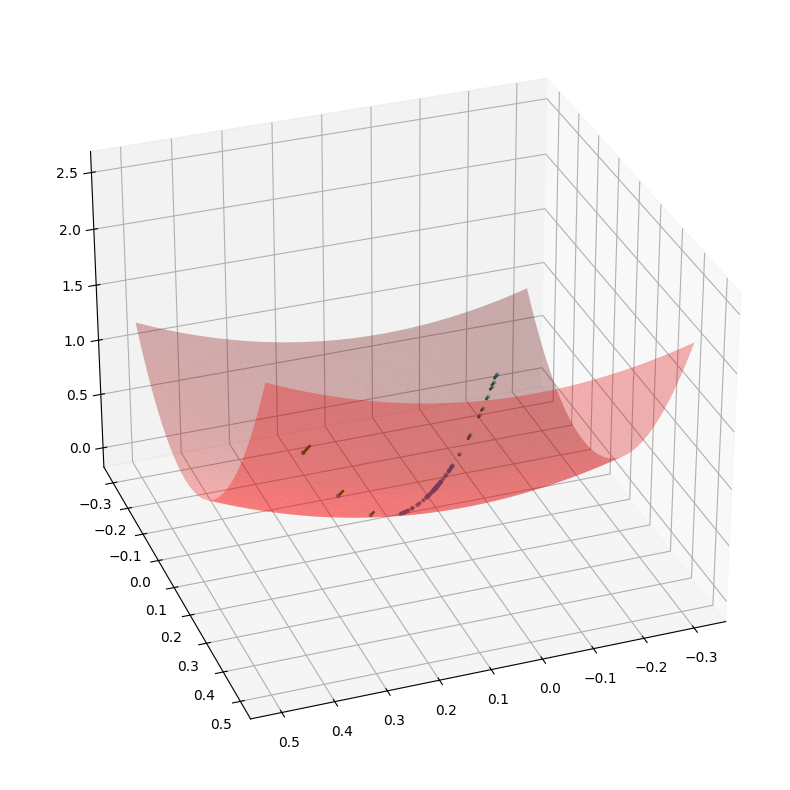

In [ ]:
## The function we are trying to minimize:
# Replace the 1 below with the scaler of your choice
##
def test_function(x,y):
    return 1 * (2*x**2 + 8*y**2) # modify me by a scalar value! (for gradient scaling)


x = torch.tensor([.5,.5], requires_grad=True) # optimizer parameters (inital location). For a comparable initial starting point, modify by the same scalar

### Make an optimizer:
optimizer = torch.optim.Adam([x], # modify me!
                             lr=.1)
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(test_function,optimizer,x)
make_graphic(test_function,weights, z_values, grad_list)

What were your findings?

### Exercise 2: Learning Rate

Play around with the learning rate and see how fast you can get the model to optimize. See what happens to the graph and the time elapsed when the learning rate is big versus when it's small. Try changing the initial values of the inputs (the x values) and see what happens. Describe your findings.

Adam optimizer elapsed time: 0.009663 seconds


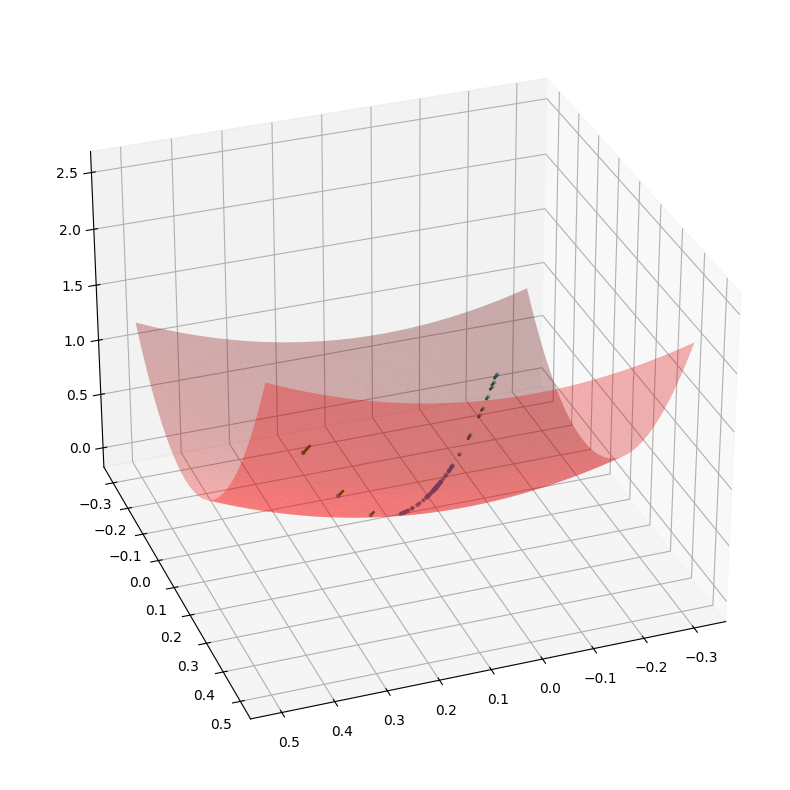

In [ ]:

def test_function(x,y):
    return (2*x**2 + 8*y**2)

x = torch.tensor([.5,.5], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.Adam([x], 
                             lr=0.1) # modify me!
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(test_function,optimizer,x)
make_graphic(test_function,weights, z_values, grad_list)

What were your results?

### Exercise 3: A More Complicated Function

Try changing the intialization point for the inputs and the learning rate on a slightly more complicated function (the banana_function below). See if there are any starting points that cause a drop in performance and describe how the learning rate changes the performance of the convergence of the function, as you did above.

Adam optimizer elapsed time: 0.012744 seconds


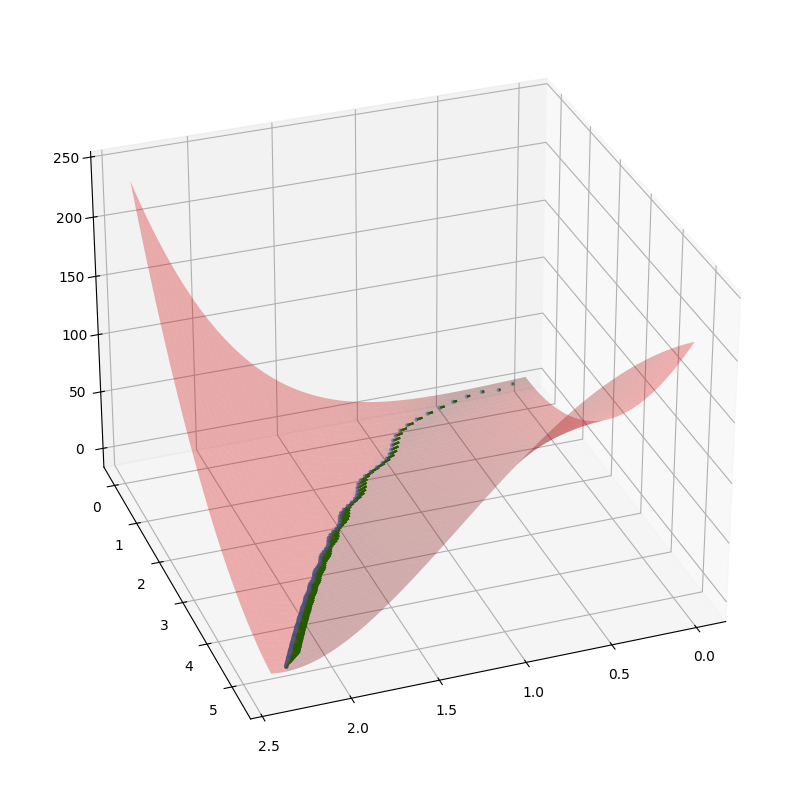

In [ ]:
def banana_function(x,y):
    return (3-x)**2 + 7*(y-x**2)**2

x = torch.tensor([0.0,0.0], requires_grad=True) #modify me!
### Make an optimizer:
optimizer = torch.optim.Adam([x], 
                             lr=.1) #modify me!
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list)

What were your results?

## Exercise 4: SGD

Now that we have gone over Adam, let's see what it was improving on. We will have you compare Adam to SGD, RMSProp, and AdaGrad.

Start with SGD. Did the speed improve or decline? How does learning rate affect the performance of the model? Is there a intial input point that makes the model do bad?

### SGD

In [11]:

x = torch.tensor([2.0,2.0], requires_grad=True)
### Make an optimizer:
# Remember, you need to pass in: [x] to your optimizer as the parameters, dont forget!
optimizer = ### YOUR CODE HERE
###
with time_block("SGD optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list)

SyntaxError: invalid syntax (4219387212.py, line 4)

What were your results?

## Exercise 5: RMSProp

Now we'll try RMSProp. Compare and contrast  RMSProp to Adam. Did the speed improve or decline? How does learning rate affect the performance of the model?

Adam optimizer elapsed time: 0.096790 seconds


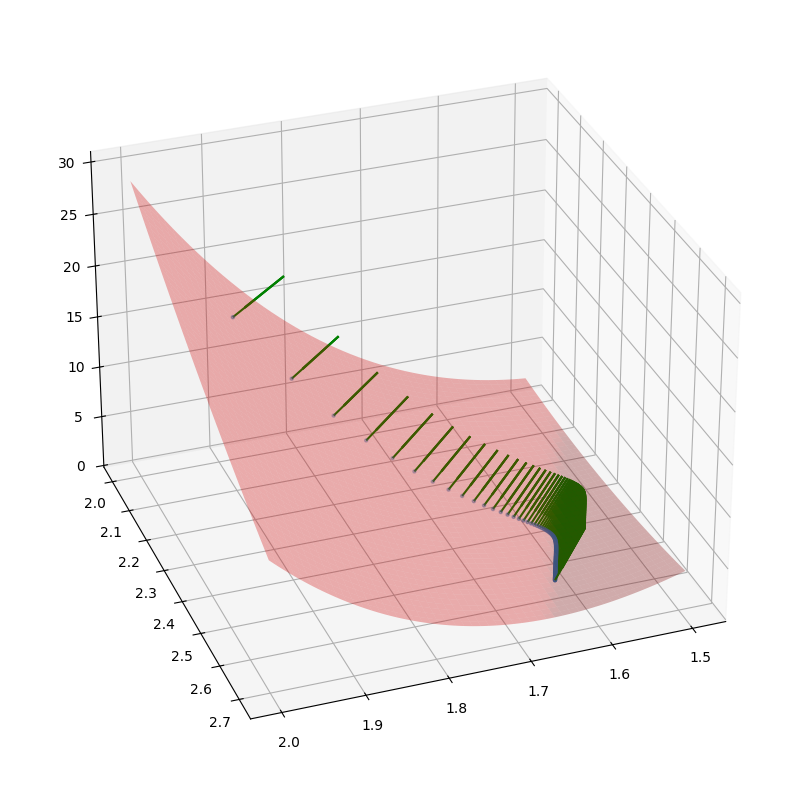

In [ ]:

x = torch.tensor([2.0,2.0], requires_grad=True)
### Make an optimizer:
# Remember, you need to pass in: [x] to your optimizer as the parameters, dont forget!
optimizer = ### YOUR CODE HERE
###
with time_block("RMSProp optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list)

What were your results?

## Exercise 6: AdaGrad

Finally, we'll try RMSProp. Compare and contrast AdaGrad to Adam. Did the speed improve or decline? How does learning rate affect the performance of the model?

Adam optimizer elapsed time: 0.052234 seconds


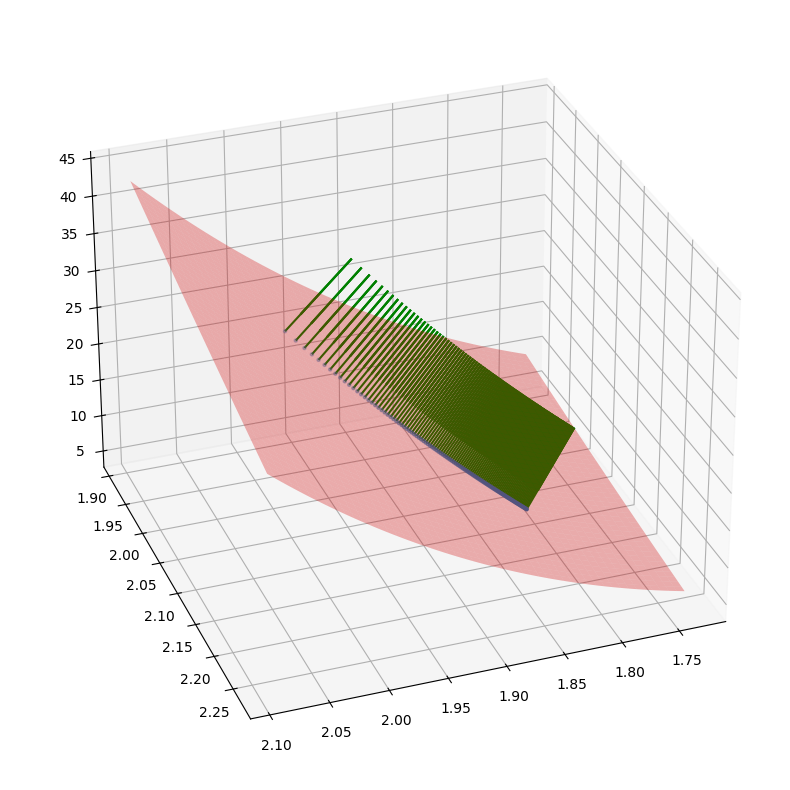

In [ ]:

x = torch.tensor([2.0,2.0], requires_grad=True)
### Make an optimizer:
# Remember, you need to pass in: [x] to your optimizer as the parameters, dont forget!
optimizer = ### YOUR CODE HERE
###
with time_block("AdaGrad optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list,elev=30,azim=70)


What were your results?

## Exercise 7: Accuracy Comparison

Visuals are a nice way of seeing how changes affect the model internally (especially bias correction), but unfortunately do not show off Adam's momentum or step annealing properties. 
To understand how these optimizers perform in accuracy as well as time, test them on the toy dataset classifier.

In [ ]:
classifier = classifier_model(64,10) #defines the model
"""
Run the classifier with the Adam Optimizer here. Modify the learning rate and training data size as you see fit.
"""
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3) #adam optimizer for the gradient decent
L = torch.nn.CrossEntropyLoss()
with time_block("Adam optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train, y_train)
    get_acc(X_test, y_test, classifier)

Final accuracy: 0.9177
Adam optimizer elapsed time: 2.301121 seconds


For an empirical example of why gradient scaling is so great.\
i) Try SGD with at least two different scalars on the training data and compare the change in accuracy to the Adam Optimizer.\
ii) Then, try a few other optimizers with different learning rates/scalars. Most of the discussed optimizers have gradient scaling invariance, but not all of them 
perform well at the same learning rate.\
iii) Addititonally try with normalized inputs, see what affect this has on the performance of the model

In [ ]:
##### Normalized training data
mean =  np.mean(X_train, axis=0, keepdims=True) 
std  = np.std(X_train, axis=0, keepdims=True)   
eps = 1e-8
X_train_norm = (X_train - mean) / (std + eps)
X_test_norm  = (X_test  - mean) / (std + eps)
##### 
classifier = classifier_model(64,10) #defines the model

optimizer = ### Add Optimizer Here!
with time_block("Your optimizer"):
    scaled_X_train =  ##### Scale the input data here! or use the normalized data, if you dont forget to edit the test set as well!
    scaled_X_test =
    final_loss = train_model(L,optimizer,classifier, scaled_X_train, y_train) #to scale the data, multipy X_train and X_test by your preferred value
    get_acc(scaled_X_test, y_test,classifier)


What were your results?


## Exercise 8: Bias Correction
One of the key differences between RMSProp and the Adam Optimizer is bias correction. To understand how important this quality is for simple data/neural networks, change the number of epochs for the above classifier to 1. Does the Adam Optimizer perform better or worse?

In [ ]:

def train_model_modified(L,optimizer,classifier, X_train, y_train, display=False):
    n_epochs = 1
    for epoch in range(n_epochs):
        loss = 0
        for X,y in zip(X_train,y_train): #y are labels
            labels = torch.tensor(y)
            inputs = torch.from_numpy(X).to(torch.float32)
        
            optimizer.zero_grad()  # Clear gradients
            outputs = classifier(inputs) #gets the outputs of the model
            train_loss = L(outputs,labels) #gets loss
            train_loss.backward() # compute accumulated gradients
            optimizer.step()# perform parameter update based on current gradients
            loss += train_loss.item() # add the mini-batch training loss to epoch loss
        loss = loss / len(X_train) # compute the epoch training loss
        if display:
            print(f"epoch : {epoch + 1}/{n_epochs}, loss = {loss}")
    return loss #this is the final loss at the end of all the training process

In [ ]:
## Your code here
classifier = classifier_model(64,10) #defines the model
L = torch.nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(classifier.parameters(), lr=1e-3) ### Add Optimizer Here
with time_block("Your optimizer"):
    final_loss = train_model_modified(L,optimizer,classifier, X_train, y_train) #to scale the data, multipy X_train and X_test by your preferred value
    get_acc(X_test, y_test,classifier)

Final accuracy: 0.8187
Your optimizer elapsed time: 0.105688 seconds


What impact did it have on the model? Compare it to the model with the orginal 15 epochs 